In [39]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.linalg import block_diag

from one_particle import *
from util import *
from delta_simple_qw import DeltaSimpleQW

In [40]:
def get_ck(psi, sign):
    ck = []
    for n in range(-L, L):
        psi_k = normalize(qw.free_eigenfun(sign=sign, k=np.pi/L*n))
        ck.append(psi.T.conj() @ psi_k)
    return np.array(ck)
    
def decompose_in_k(psi, k0):
    ck_plus = get_ck(psi, sign=1)
    ck_minus = get_ck(psi, sign=-1)
    norm = sum(np.abs(ck_plus)**2) + sum(np.abs(ck_minus)**2)
    assert abs(norm-1) < 1e-3, norm
    plt.xlabel('k')
    plt.ylabel(r'$\vert{c_k}\vert^2$')
    plt.title('Mode decomposition')
    plt.xticks([k0, k0-np.pi, -k0, -k0+np.pi], [r'$k_0$', r'$k_0-\pi$', r'$-k_0$', r'$\pi-k_0$'])
    p = plt.plot(np.arange(-L, L)*np.pi/L, np.abs(ck_plus)**2)
    return p

In [3]:
EPS = 1e-9

# A first possible experiment

We consider a closed chain of length $2L$, positions are labelled by $x=-L, \dots, L-1$. The QW walk is given by $U=WV$ with
$$
W = \begin{pmatrix}
    \alpha T^2 & i\beta T\\
    i\beta T^\dagger & \alpha(T^2)^\dagger
\end{pmatrix}\,,
$$
and 
$$
V = \mathbb{I}+\begin{pmatrix}
    c-1 & is e^{-i\gamma}\\
    is e^{i\gamma} & c-1
\end{pmatrix}\otimes \lvert 0\rangle \langle 0 \rvert\,.
$$
Above, $T\lvert x\rangle = \lvert x+1\rangle$ is the translation operator, $\alpha=\cos{\theta}$, $\beta=\sin{\theta}$, and $c=\cos{\phi}$, $s=\sin{\phi}$

Consider the eigenproblem $U\lvert\psi\rangle = e^{i\omega} \lvert\psi\rangle$. Generically, we have 4 solutions to this equation labelled by momenta $(k, k-\pi, -k, -k+\pi)$.

## Unreasonable resources

First, we consider the simulation of a scattering through the potential without thinking about experimental constraints. In particular, we consider long evolution times and rather broad wavepackets. The goal is to show the phenomenon we'd like to see in the lab.

We consider a QW with parameters $L=300$, $\theta=\pi/4$, $\phi=\pi/3$, and $\gamma=3\pi/4$. 

In [8]:
L = 300
theta = np.pi/4
phi = np.pi/3
gamma = 3*np.pi/4
qw = DeltaSimpleQW(L=L, theta=theta, phi=phi, gamma=gamma)

We prepare an initial gaussian packet localized at $x_0=-100$ travelling to the right with momentum close to $k_0=\pi/4$ ($\sigma_k=0.1$). We will track the evolution of the wavepacket as it scatters on the potential. 

We will see that the scattering excites modes with momenta $k_0-\pi$ and $\pi-k_0$, not only $-k_0$. This is the same physics found for the Thirring QCA [[Bisio et al. 2018]](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.032132), and it's what we'd like to observe. 

In [9]:
k0 = np.pi/4
sigma_k = 0.1
x0 = -100
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=1))

The evolution looks like this.

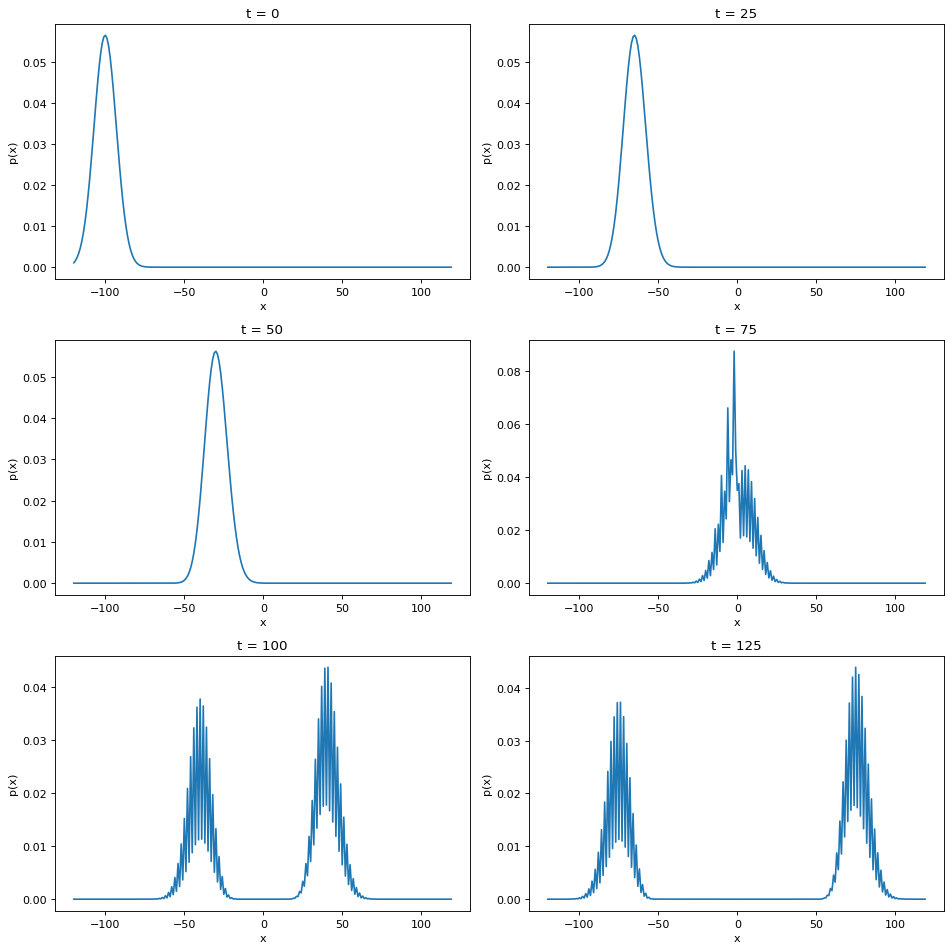

In [10]:
steps = 5
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(3, 2, 1)
plot_x(qw, -120, 120)
plt.title(f't = 0')
for i in range(steps):
    qw.evolve(25)
    fig.add_subplot(3, 2, i+2)
    plot_x(qw, -120, 120)
    plt.title(f't = {25*(i+1)}')
fig.tight_layout()
plt.show()

After the scattering with the potential, we have two wavepackets, corresponding to transmitted and reflected waves. 

The oscillating behaviour on small scales is due to the interference between modes with momenta $k_0$ and $k_0-\pi$, and $-k_0$ and $-k_0+\pi$. Observing this interference pattern is one possible way to show that modes with momenta $k_0-\pi$ and $-k_0+\pi$ are excited. 

Another way it to decompose the outcoming signal in the momentum eigenbasis.

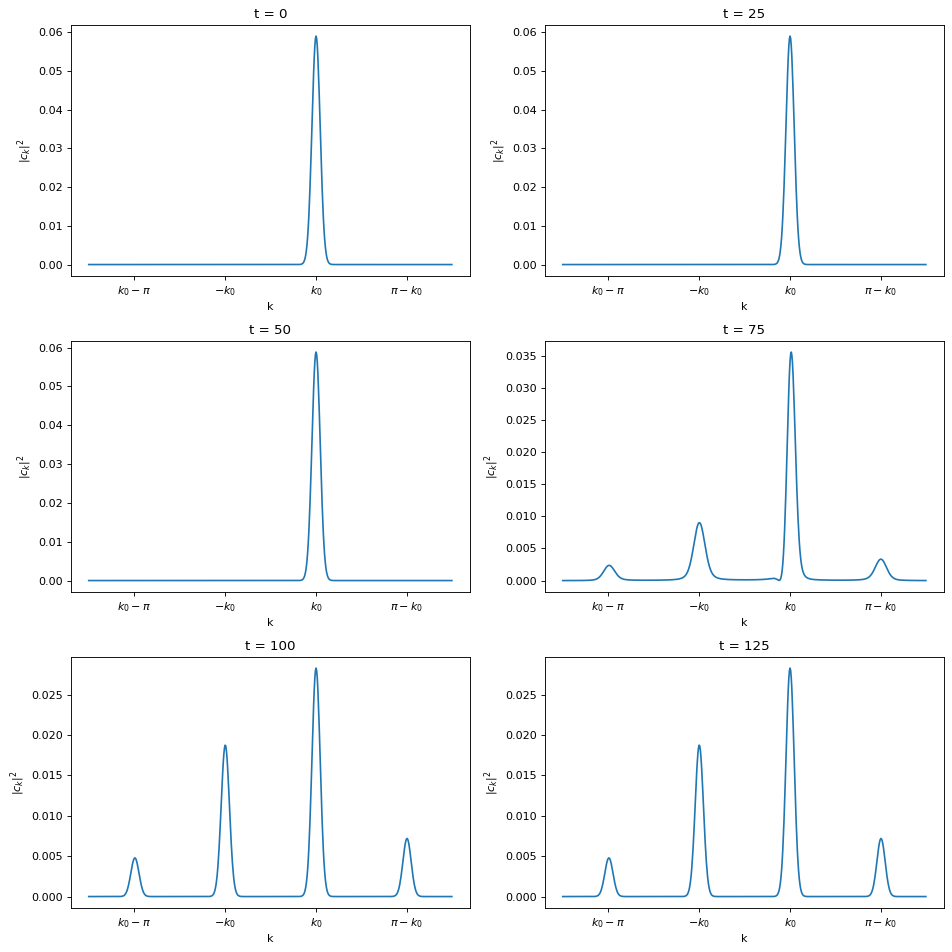

In [12]:
k0 = np.pi/4
sigma_k = 0.1
x0 = -100
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=1))
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(3, 2, 1)
decompose_in_k(qw.psi, k0)
plt.title(f't = 0')
steps = 5
for i in range(steps):
    qw.evolve(25)
    fig.add_subplot(3, 2, i+2)
    decompose_in_k(qw.psi, k0)
    plt.title(f't = {25*(i+1)}')
fig.tight_layout()
plt.show()

We see that the signal, initially prepared with a momentum picked at $k_0$, develops 3 other picks after scattering with the potential.

## Reasonable resources (?)

We try to find parameters for which the interference pattern is still visible, while satisfying the experimental constraints. In particular, we try to minimize the number of time steps necessary to see the interference pattern.

We choose the following parameters: $L=100$, $\theta=\pi/4$, $\gamma=3\pi/4$, $k_0=\pi/4$, $\sigma_k=0.4$, and $x_0=-5$.

In [13]:
L = 100
theta = np.pi/4
gamma = 3*np.pi/4
k0 = np.pi/4
sigma_k = 0.4
dk = np.pi/L
x0 = -5

First consider the model without interaction.

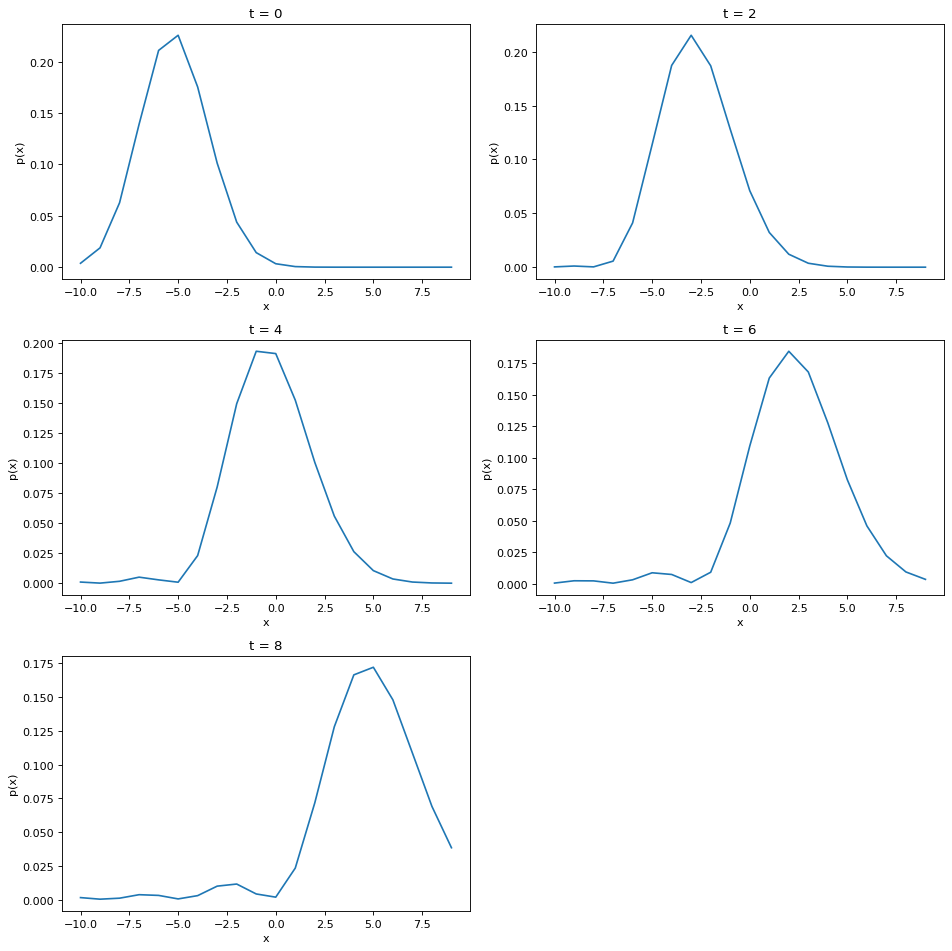

In [16]:
phi = 0
qw = DeltaSimpleQW(L=L, theta=theta, phi=phi, gamma=gamma)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=1))
steps = 4
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(3, 2, 1)
plot_x(qw, -10, 10)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(3, 2, i+2)
    plot_x(qw, -10, 10)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.show()

The point here is that the wavepacket is small enough (and fast enough), that it has the time to go completely from one side of $x=0$ to the other. 

We now introduce the interaction, with $\phi=\pi/3$ and $\gamma = 3\pi/4$.

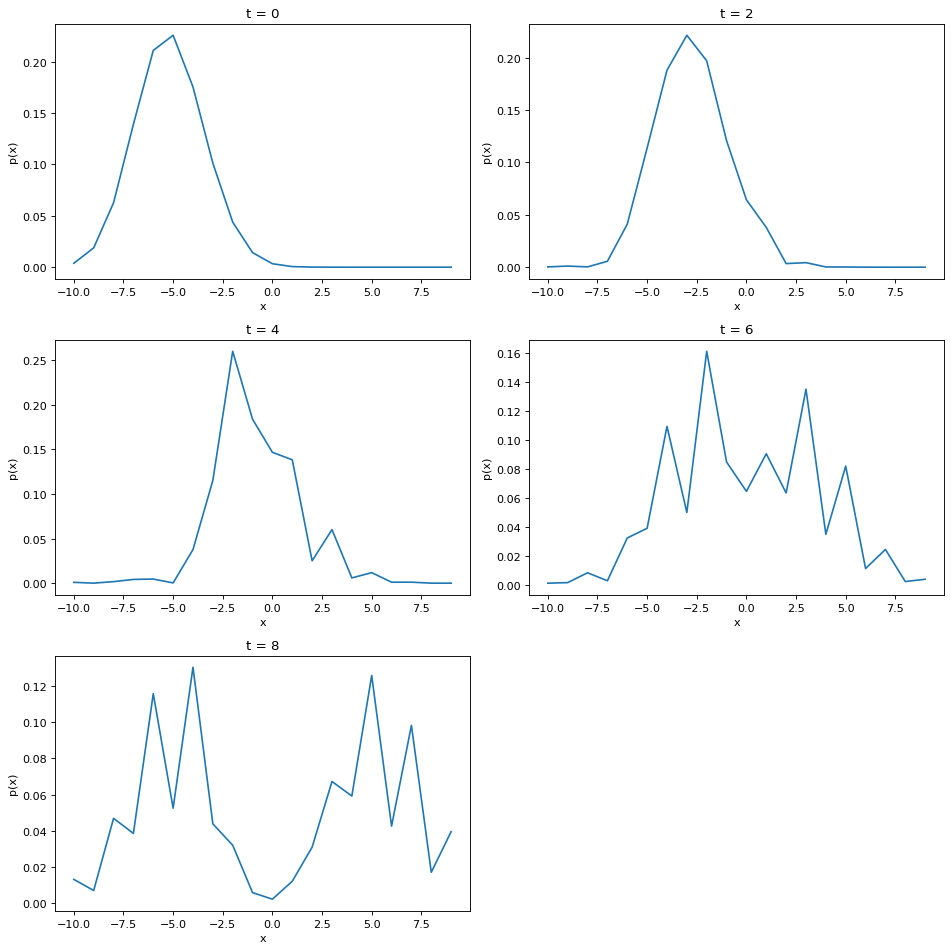

In [20]:
phi = np.pi/3
qw = DeltaSimpleQW(L=L, theta=theta, phi=phi, gamma=gamma)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=1))
#plt.figure(figsize=(10, 6), dpi=80)
steps = 4
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(3, 2, 1)
plot_x(qw, -10, 10)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(3, 2, i+2)
    plot_x(qw, -10, 10)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.show()

We see that the packet has enough time to split in two separate wavepackets (reflected and transmitted), and the interference patterns are clearly visible.

We also consider the same scattering process in momentum space.

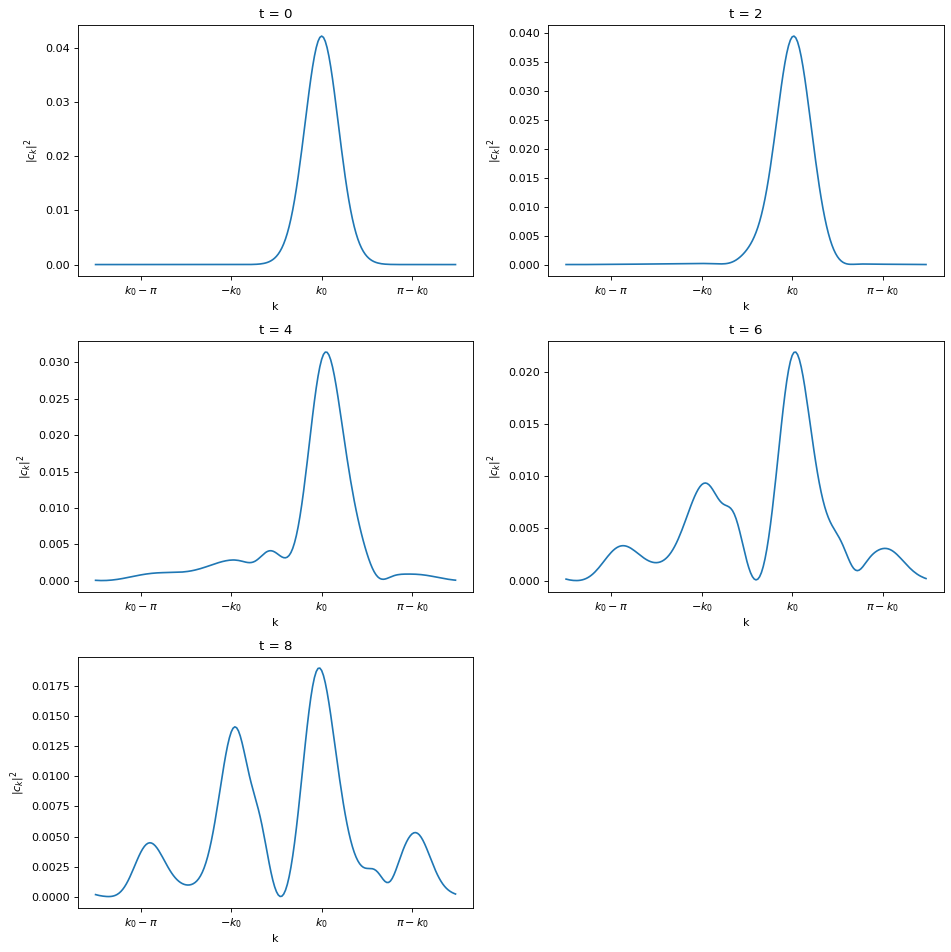

In [21]:
phi = np.pi/3
qw = DeltaSimpleQW(L=L, theta=theta, phi=phi, gamma=gamma)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=1))
steps = 4
ps = []
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(3, 2, 1)
decompose_in_k(qw.psi, k0)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(3, 2, i+2)
    decompose_in_k(qw.psi, k0)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.show()

## Other things

### Convergence rate

We check at what times the momentum distribution changes appreciably.

In [25]:
L = 300
theta = np.pi/4
phi = np.pi/3
gamma = 3*np.pi/4
qw = DeltaSimpleQW(L=L, theta=theta, phi=phi, gamma=gamma)
k0 = np.pi/4
sigma_k = 0.05
x0 = -100
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=1))
ck_old = get_ck(qw.psi, sign=1)
steps = 200
changes = []
for _ in range(steps):
    qw.evolve()
    ck_new = get_ck(qw.psi, sign=1)
    changes.append(np.linalg.norm(np.abs(ck_new)-np.abs(ck_old)))
    ck_old = ck_new

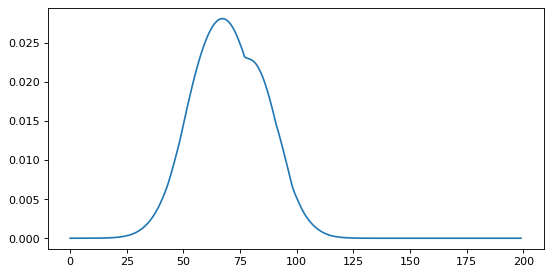

In [26]:
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(changes)

### Comparison with analytical result

We check that the numerics agree with the analytical solution.

In [28]:
# find S-matrix
H = np.array([[1, 1], [1,-1]])/np.sqrt(2)
UH = block_diag(H, H)
a = np.cos(theta)
b = np.sin(theta)
c = np.cos(phi)
s = np.sin(phi)
g = gamma
k = k0
w = DeltaSimpleQW.get_omega(sign=1, k=k, alpha=a)
gp = DeltaSimpleQW.get_gp(sign=1, k=k, alpha=a)
gm = DeltaSimpleQW.get_gp(sign=1, k=-k, alpha=a)
Np = np.sqrt(b**2+np.abs(gp)**2)
Nm = np.sqrt(b**2+np.abs(gm)**2)
SO = np.array([[0, -a*c*gp, a*b*s*np.exp(1j*g), a*gm],
               [-a*np.exp(-1j*k)*gp, b*s*np.exp(-1j*g)*gp, np.exp(1j*(w-k))*gm+b**2*c, 0],
               [0, np.exp(1j*(w-k))-c*gp, b*s*np.exp(1j*g), -a*np.exp(-1j*k)],
               [a*b, -a*s*np.exp(-1j*g)*gp, -a*b*c, 0]
              ])
# normalize columns
SO[:,0:2] /= Np
SO[:,2:] /= Nm
SI = np.array([[-a*b*s*np.exp(1j*g), -a*gp, 0, a*c*gm],
              [-np.exp(1j*(w+k))*gp-b**2*c, 0, a*np.exp(1j*k)*gm, -b*s*np.exp(-1j*g)*gm],
              [-b*s*np.exp(1j*g), a*np.exp(1j*k), 0, c*gm-np.exp(1j*(w+k))],
              [a*b*c, 0, -a*b, a*s*np.exp(-1j*g)*gm]]
             )
SI[:,0:2] /= Np
SI[:,2:] /= Nm
S = np.linalg.inv(UH) @ np.linalg.inv(SO) @ SI @ UH

In [29]:
# check that the S-matrix is unitary
with np.printoptions(precision=3, suppress=True):
    assert np.allclose(S@S.T.conj(), np.eye(4))
    assert np.allclose(S.T.conj()@S, np.eye(4))

In [30]:
# incoming wave
i = np.array([1, 0, 0, 0])

In [31]:
# outgoing wave
o = S@i

In [32]:
# momentum distribution for outgoing wave: (k0, k0-pi, -k0, -k0+pi)
np.abs(o)**2

array([0.48      , 0.08      , 0.31797959, 0.12202041])

In [33]:
# get momentum distribution from numerics
ck = get_ck(qw.psi, sign=1)

In [34]:
def k_to_n(k, L):
    return L+int(L*k/np.pi)

Find the relative size of the 4 picks in momentum distribution found with the numerics and check that they agree with the analytical result.

In [35]:
n0 = k_to_n(k0, L)
sum([np.abs(ck[n0+i])**2 for i in range(-40, 40)])

0.4794853816663492

In [36]:
n1 = k_to_n(k0-np.pi, L)
sum([np.abs(ck[n1+i])**2 for i in range(-40, 40)])

0.08019128144423

In [37]:
n2 = k_to_n(-k0, L)
sum([np.abs(ck[n2+i])**2 for i in range(-40, 40)])

0.3182514494529881

In [38]:
n3 = k_to_n(-k0+np.pi, L)
sum([np.abs(ck[n3+i])**2 for i in range(-40, 40)])

0.12207188743631185

We find agreement between the simulation and the analytical result.